In [37]:
# Custom Dataset 클래스 정의
import os
import torch
from torch.utils.data import Dataset
import numpy as np


class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = []

        for subdir, dirs, files in os.walk(root_dir):
            for file in files:
                file_path = os.path.join(subdir, file)
                # file_list에 파일 경로를 추가
                self.file_list.append(file_path)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        npy_path = self.file_list[idx]
        data = np.load(npy_path)
        data = data.flatten()
        # 4n-1번째 인덱스(visibility)가 0.5보다 작으면 4n-2, 4n-3, 4n-4번째 인덱스를 0으로 바꿔줌
        # for i in range(0, len(data), 4):
        #     if data[i + 3] < 0.5:
        #         data[i] = 0
        #         data[i + 1] = 0
        #         data[i + 2] = 0
        #         data[i + 3] = 0

        # 4n-1번재 인덱스를 모두 삭제
        data = np.delete(data, np.arange(3, len(data), 4))

        # pushup, squat, pullup
        if "pushup" in npy_path:
            label = 0
        elif "squat" in npy_path:
            label = 1
        elif "pullup" in npy_path:
            label = 2
        else:
            label = 3

        return data, label

In [4]:
# 데이터셋 및 데이터로더 생성
pushup_dataset = CustomDataset(root_dir="D:/dataset/landmark/pushup")
squat_dataset = CustomDataset(root_dir="D:/dataset/landmark/squat")
pullup_dataset = CustomDataset(root_dir="D:/dataset/landmark/pullup")

In [6]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

pushup_train, pushup_test = train_test_split(
    pushup_dataset, test_size=0.2, random_state=42
)
squat_train, squat_test = train_test_split(
    squat_dataset, test_size=0.2, random_state=42
)
pullup_train, pullup_test = train_test_split(
    pullup_dataset, test_size=0.2, random_state=42
)

train_dataset = pushup_train + squat_train + pullup_train
test_dataset = pushup_test + squat_test + pullup_test

In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [8]:
# 모델 생성
import torch.nn as nn

class Classification(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(99, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 3)

    def forward(self, x):
        x = nn.Identity()(self.fc1(x))
        x = nn.Identity()(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
model = Classification()

In [46]:
# 모델 학습
import torch.optim as optim
from tqdm.notebook import tqdm

# 모델 학습을 위한 optimizer와 loss 함수 정의
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 학습 시작
for epoch in tqdm(range(20)):
    running_loss = 0.0
    for data in train_loader:
        inputs, labels = data
        optimizer.zero_grad()

        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    print(f"Epoch: {epoch}, Loss: {running_loss}")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0, Loss: 8.299203678931818
Epoch: 1, Loss: 7.1403109417758035
Epoch: 2, Loss: 7.402617806526446
Epoch: 3, Loss: 7.47745869504343
Epoch: 4, Loss: 6.722454297845208
Epoch: 5, Loss: 6.589048287690854
Epoch: 6, Loss: 7.394979689555778
Epoch: 7, Loss: 6.762654172267649
Epoch: 8, Loss: 6.0652198990576585
Epoch: 9, Loss: 7.665271193853315
Epoch: 10, Loss: 7.086269318081989
Epoch: 11, Loss: 7.88278155985471
Epoch: 12, Loss: 7.121334216943101
Epoch: 13, Loss: 6.163948919745298
Epoch: 14, Loss: 6.464087330367805
Epoch: 15, Loss: 5.752556791532086
Epoch: 16, Loss: 6.015340110674887
Epoch: 17, Loss: 7.407606418049358
Epoch: 18, Loss: 5.706272137046521
Epoch: 19, Loss: 5.368439449616066


In [55]:
from torch.utils.data import DataLoader

new_test_dataset = CustomDataset(root_dir="D:/dataset/landmark/test")
new_test_dataset = list(test_dataset) + list(new_test_dataset)
new_test_loader = DataLoader(new_test_dataset, batch_size=1, shuffle=True)

In [64]:
from sklearn import metrics
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
import torch.nn.functional as F

# 모델 평가
model.eval()
y_true = []
y_pred = []

for data in new_test_loader:
    inputs, labels = data
    outputs = model(inputs.float())
    probability = F.softmax(outputs, dim=1)
    
    if torch.max(probability) < 0.9999:
        predicted = torch.tensor([3])
    else:
        predicted = torch.argmax(probability, 1)
    
    y_true.append(labels.item())
    y_pred.append(predicted.item())
    
# 멀티 클래스 분류 평가 지표
print("Accuracy: ", accuracy_score(y_true, y_pred))
print("------macro------")
print("Precision: ", precision_score(y_true, y_pred, average='macro'))
print("Recall: ", recall_score(y_true, y_pred, average='macro'))
print("F1 score: ", f1_score(y_true, y_pred, average='macro'))

print(metrics.classification_report(y_true, y_pred))

Accuracy:  0.8451636016240746
------macro------
Precision:  0.8178569417295705
Recall:  0.7802666938256158
F1 score:  0.7514408348169322
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     11490
           1       0.81      0.98      0.89     12001
           2       0.85      0.98      0.91     11203
           3       0.71      0.16      0.26      7176

    accuracy                           0.85     41870
   macro avg       0.82      0.78      0.75     41870
weighted avg       0.83      0.85      0.80     41870



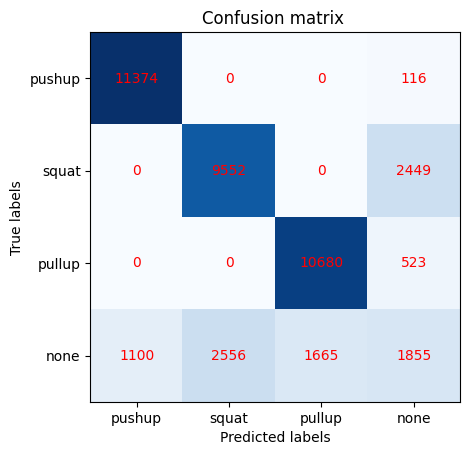

In [63]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title('Confusion matrix ')
# 수치 표시
for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')
# 클래스 이름 표시
plt.xticks([0, 1, 2, 3], ["pushup", "squat", "pullup", "none"])
plt.yticks([0, 1, 2, 3], ["pushup", "squat", "pullup", "none"])
plt.show()